https://www.kaggle.com/snap/amazon-fine-food-reviews/data#

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import string
import seaborn as sns

%matplotlib inline

In [2]:
con = sqlite3.connect('database.sqlite')

In [3]:
filtered_data = pd.read_sql_query(""" SELECT * from Reviews where score!= 3""", con)

In [4]:
# positive and negative rating

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

filtered_data['Score'] = filtered_data['Score'].apply(partition)


In [5]:
filtered_data.shape

(525814, 10)

In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Data cleaning

In [7]:
sum(filtered_data.duplicated())

0

In [8]:
sorted_data = filtered_data.sort_values('ProductId', axis = 0, ascending=True)

In [9]:
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [10]:
#Looks like products are slightly different and probably user has given one review comments, but the Amazon has added in
#all the products in the same productId

#Remove the duplicates

final = sorted_data.drop_duplicates(subset={'UserId', 'ProfileName','Time', 'Text'}, keep='first', inplace=True)

In [11]:
final

In [12]:
filtered_data.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [13]:
final = filtered_data[filtered_data['HelpfulnessNumerator'] <= filtered_data['HelpfulnessDenominator']]

In [14]:
final.shape

(525812, 10)

In [15]:
final['Score'].value_counts()

positive    443775
negative     82037
Name: Score, dtype: int64

### Convert text to vector

Review Text ----convert----> d-dim vectors

If W^TXi is greater than 0 then review will be positive.

if W^TXi is lesser than 0 then review will be negative.

Lets there are 3 reviews r1,r2,r3

r1 and r2 are similar and r1 and r3 are similiar

r1 and r2 are similar so that correspondence vector v and v2 must close each other.

Similar text must be closer geometrically.

Converting text to vector: 
        
            BOW ( Bag of Words)
            TF-IDF
            W2V ( Word to vector)
            Avg W2V
            TF-IDF W2V

#### Bag of Words (BOW)

    . Simplest technique to convert text to vector.
    
    Example:
     Review 1: This pasta is very tasty and affordable.
     Review 2: This pasta is not tasty and is affordable.
     Review 3: This pasta is delicious and cheap.
     Review 4: Pasta is tasty and pasta tastes good.
     
     
     BOW Concept:
     
     Step1: Construct dictionary: Set of all unique words from all reviews.
     
     Step2: For all reviews ri construct vector vi
     
         Each vi index contains the correspondence words.
         
         Each cell contains the no of word occurs in review.
         
         This vector Vi will be sparse matrix..because most of the elements become 0.
         
    
    r1: This pasta is very tasty and affordable.
    
    r2: This pasta is not tasty and is affordable.
    
    
    Unique word : This, pasta, is, very, not, tasty, and, is, affordable
    
    Word count for V1 :
    
        This : 1, pasta : 1 , is : 1, very: 1, not: 0, tasty: 1, and: 1, is: 0, affordable: 1
        
    Word count for v2:
        
        This : 1, pasta : 1 , is : 1, very: 0, not: 1, tasty: 1, and: 1, is: 1, affordable: 1
    
    Now length of v1 and v2 = v1 - v2 = diffence betwween v1 and v2 = root(1 + 1 +1) = root(3).
    
    so length of root 3 is very close so ..this is the problem in BOW. Because it does not work very well in small changes.
    
 ##### Text pre-processing ( Stemming, Stop word removal, Tokenization, Lemmatization)
 
 Some words are not important, when we are putting in vectors these words do not matters. Just remove these words which is called stopwords.
 
 Sometimes removing stopwords is very dangereous.
 
 Strategy:
 
     1. Removing stop words.
     
     2. Everything use lowercase.
     
     3. Replace with stem word.
             tasty and tasteful ...taste is stem word.
             
     4. Lemmatization: Breaking the sentences in to words.
             
             location will not break like ( New York)
             lemmatization knows how to break the sntence.
             
    
 Drawback:
     
     Not taking the semantic meaning of words like cheap and affordable
 
 Concept of Uni-gram, Bi-gram and n-gram
 
     Uni-gram : Each word consider as dimension. One word adding in to the vector.
     
     Bi-gram : Pair of words considering as dimension. 2 consecutive word creating the dimension.
     
     Tri-gram : 3 consecutive word creating the dimension.
     
     n-gram : n consecutive word creating the dimension.
     
     
     bi-gram and n-gram retains the sequence information.
     
#### TF-IDF ( Term frequency - Inverse document frequency)
    
    From BOW, we learn that
    
    r1: w1, w2, w3, w2, w5
    
    r2: w1, w3,w4,w5,w6,w2
    
    v1 : w1: 1, w2:2 , w3:1, w4: 0, w5:1
    
    v2: w1:1,w2:1,w3:1,w4:1,w5:1,w6:1
    
    Formula of TF = No of word occurs in rj / Total no of words in rj
    
    TF(w2, r1) = 2/5
    
    IDF:
        IDF measures how important of term is.
        
        idf(wi, D) = log(N/ni)
        
        where D = list of reviews in doc
        
        N = No of docs
        
        ni = no of docs which contains word wi
        
        Next step is combine TF * IDF

In [16]:
# Remove HTML tag
# Remove punctuation
# Keep english letter not alpha numeric.
# Length of word should greater than 2.
# Convert word to lower case.
# Remove stop word
# Finally snow ball stemming the word.


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import string

In [17]:
#Set the english stop word

stop_word = set(stopwords.words('english'))
snow = nltk.stem.SnowballStemmer('english')

In [18]:
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|\"|#]', r'', sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]', r'', cleaned)
                     
    return cleaned

In [19]:
def clean_html(sentence):
    clean = re.compile('<.*?>')
    clean_text = re.sub(clean, '', sentence)
    
    return clean_text

In [20]:
print(stop_word)

{'yourself', 'as', 'y', 'off', 'yourselves', 'were', "couldn't", "you'd", 'all', 'up', 'too', 'can', 'me', 'don', 'above', 'didn', 'on', 'before', 'now', 'what', 'why', 'them', 'hadn', 'it', 'we', "she's", 'its', 'our', 'ours', 'no', "isn't", 'most', 's', 'here', 'where', 'out', 'weren', 'while', 'did', 'but', 'some', 'itself', 'yours', 'which', 'herself', "weren't", 'nor', 'isn', 'own', 'doesn', 'until', 'into', 'ourselves', 'had', 'do', 't', 'be', 'needn', 'that', 'my', 'myself', "won't", 'been', 'who', 'does', 'a', 've', 'with', 'just', 'he', "shouldn't", 'only', 'these', 'are', 'if', 'at', 'the', 'other', 'than', 'themselves', 'each', 'very', 'll', 'won', 'whom', 'wouldn', 'was', 'because', 'have', 'm', 'mightn', "didn't", 'any', 'couldn', 'an', 'him', 'in', 'shan', 'both', 'hers', 'down', "it's", 'over', "doesn't", 'further', 'for', 'your', "mightn't", 'being', 'doing', "should've", 'am', 'how', 'about', 'having', "wouldn't", 're', "hadn't", 'below', "don't", 'you', 'there', 'to',

In [21]:
print(snow.stem('tasteful'))

tast


In [22]:
i = 0
str1 = ''
final_string=[]
all_positive_words=[]
all_negative_words=[]
s=''

for sent in final['Text'].values:

    filtered_sentence = []
    
    sente = clean_html(sent)

    for w in sente.split():
        for cleaned_word in clean_punctuation(w).split():
            if (cleaned_word.isalpha()) & (len(cleaned_word) > 2):
                if cleaned_word.lower() not in stop_word:
                    s = snow.stem(cleaned_word.lower()).encode('utf8')
                    filtered_sentence.append(s)
                    
                    if i >= final['Score'].values.size:
                        break
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s)
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence)
    final_string.append(str1)
    i +=1

final['Cleaned Text'] = final_string

final.head()

C:\Users\Jyotiprakash Das\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanutsth pea...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citrus ...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,b'look secret ingredi robitussin believ found ...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,b'great taffi great price wide assort yummi ta...


In [23]:
# Store the final table in to a sqlite table for future

conn = sqlite3.connect('final.sqlite')
c = conn.cursor()

conn.text_factory= str

final.to_sql('Reviews', conn, schema = None, if_exists= 'replace', index=True, index_label=None, chunksize=None, dtype=None)

C:\Users\Jyotiprakash Das\Anaconda3\lib\site-packages\pandas\core\generic.py:2712: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [24]:
# Frequency distribution of the words
print(all_positive_words)
freq_dist_positive = nltk.FreqDist(all_positive_words)
print('most common positive word', freq_dist_positive.most_common(20))
freq_dist_negative = nltk.FreqDist(all_negative_words)
print('most common negative word', freq_dist_negative.most_common(20))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



most common positive word [(b'like', 206093), (b'tast', 179994), (b'love', 164116), (b'flavor', 160030), (b'good', 158476), (b'great', 146894), (b'one', 141030), (b'use', 137733), (b'coffe', 128173), (b'tri', 125263), (b'product', 122300), (b'tea', 119800), (b'food', 112508), (b'get', 106678), (b'make', 100693), (b'would', 80730), (b'dog', 79594), (b'eat', 79218), (b'time', 76819), (b'buy', 76083)]
most common negative word [(b'tast', 48058), (b'like', 47366), (b'product', 38493), (b'one', 29758), (b'flavor', 28334), (b'would', 26653), (b'tri', 26076), (b'food', 24766), (b'coffe', 22882), (b'use', 21446), (b'good', 21386), (b'buy', 20166), (b'get', 20094), (b'order', 17954), (b'dog', 17603), (b'eat', 17448), (b'tea', 17250), (b'dont', 17237), (b'even', 16424), (b'box', 15258)]


In [25]:
#Taking first 1k positive and first 1k negative
data_p=final[final['Score']=='positive'].head(n = 1000)
data_n=final[final['Score']=='negative'].head(n = 1000)
final_2k=pd.concat([data_p, data_n])

In [26]:
Score_2k=final_2k['Score']

In [27]:
print(final_2k.shape)
print(Score_2k.shape)

(2000, 11)
(2000,)


### BOW

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,2))
final_bigram_counts = count_vect.fit_transform(final_2k['Cleaned Text'].values)

In [30]:
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 62944)
the number of unique words including both unigrams and bigrams  62944


### TF-IDF

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
tf_idf_vect = TfidfVectorizer(ngram_range = (1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_2k['Cleaned Text'].values)

final_tf_idf.get_shape()

(2000, 62944)

In [33]:
features = tf_idf_vect.get_feature_names()

len(features)

62944

In [34]:
features[100000:100010]

[]

In [35]:
#convert a row in sparse matrix to a numpy array
print(final_tf_idf[3,:].toarray()[0])

[0. 0. 0. ... 0. 0. 0.]


In [36]:
#Get top 25 tfidf values in a row

def top_tfidf_feats(row, features, top_n = 25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [ (features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['features', 'tfidf']
    
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0], features, 25)

In [37]:
print(top_tfidf)

           features     tfidf
0             witch  0.249534
1              tini  0.163051
2             treat  0.138265
3              lewi  0.124767
4    confect around  0.124767
5    around centuri  0.124767
6     wardrob treat  0.124767
7         lewi lion  0.124767
8        liber coat  0.124767
9           confect  0.124767
10   treat familiar  0.124767
11          filbert  0.124767
12   citrus gelatin  0.124767
13    witch wardrob  0.124767
14      treat seduc  0.124767
15  recommend yummi  0.124767
16      yummi treat  0.124767
17      filbert cut  0.124767
18   familiar stori  0.124767
19    light pillowi  0.124767
20   brother sister  0.124767
21       tini mouth  0.124767
22     seduc edmund  0.124767
23            seduc  0.124767
24       stori lewi  0.124767


### Bow using sklearn (Example)

In [38]:


from sklearn.feature_extraction.text import CountVectorizer



In [39]:
strings = ["the method of lagrange multipliers is the economists workhorse for solving optimization problems",
           "the technique is a centerpiece of economic theory but unfortunately its usually taught poorly"]

In [40]:
vec = CountVectorizer()

In [41]:
feature_matrix = vec.fit_transform(strings)

In [42]:
feature_matrix.get_shape()

(2, 22)

In [43]:
feature_matrix.toarray()

array([[0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0]],
      dtype=int64)

### BOW using custom implementation( Example)

In [44]:

from collections import Counter
from scipy.sparse import csr_matrix


strings = ["the method of lagrange multipliers is the economists workhorse for solving optimization problems",
           "the technique is a centerpiece of economic theory but unfortunately its usually taught poorly"]

def get_unique_word(sentences):
    unique_word = set()
    if isinstance(sentences, (list,)):
        for sentence in sentences:
            for word in sentence.split():
                if len(word) < 2:
                    continue
                unique_word.add(word)
        unique_word = sorted(list(unique_word))
        
        vocab = {j:i for i, j in enumerate(unique_word)}
        
        return vocab
    else:
        print('Wrong input')
    
def get_frequency_word_of_sparse_matrix(sentences, unique_words):
    
    rows = []
    columns = []
    values = []
    idx = 0
    
    if isinstance(sentences, (list,)):
        for sentence in sentences:
            word_freq = dict(Counter(sentence.split()))
            
            for word, freq in word_freq.items():
                if len(word) < 2:
                    continue
                col_index = unique_words.get(word, -1)
                
                if col_index != -1:
                    rows.append(idx)
                    columns.append(col_index)
                    values.append(freq)
            idx +=1
        return csr_matrix((values, (rows, columns)), shape= (len(sentences), len(unique_words)))
    else:
        print('wrong input')
    


In [45]:
vocab = get_unique_word(strings)

A = get_frequency_word_of_sparse_matrix(strings, vocab)

print(A.toarray())

[[0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 2 0 0 0 1]
 [1 1 1 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1 1 1 0]]


Summery: sklearn results and my customs results are same.

### TFIDF sklearn example

In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer


strings = [' This is my first string', 'This is my second string', 'This is my third string', ' is it my first string']

tfidf_vect = TfidfVectorizer()

vectorizer = tfidf_vect.fit(strings)
tfidf = vectorizer.transform(strings)

In [60]:
tfidf.get_shape()

(4, 8)

In [57]:
vectorizer.get_feature_names()

['first', 'is', 'it', 'my', 'second', 'string', 'third', 'this']

In [58]:
vectorizer.idf_

array([1.51082562, 1.        , 1.91629073, 1.        , 1.91629073,
       1.        , 1.91629073, 1.22314355])

In [61]:
print(tfidf[0])

  (0, 7)	0.46979138557992045
  (0, 5)	0.38408524091481483
  (0, 3)	0.38408524091481483
  (0, 1)	0.38408524091481483
  (0, 0)	0.5802858236844359


### TFIDF custom implementation

In [73]:
def get_no_of_word_count(word, dataset):
    
    count = 0
    
    for row in dataset:
        
        word_dict = dict(Counter(row.split()))
        
        if word in word_dict.keys():
            count += 1
            
    #print(F'word count for: {word} is {count}')    
    return count
def get_idf(sentences, unique_words):
    rows = []
    columns = []
    values = []
    vocabulary = []
    word_count = {}
    tf_idf = {}
    idx = 0
    N = len(sentences)
    
    if isinstance(sentences, (list,)):
        for sentence in sentences:
            word_freq = dict(Counter(sentence.split()))
            total_word_count = len(sentence.split())
            for word, val in word_freq.items():
                tf = val/ total_word_count
                ni = get_no_of_word_count(word, sentences)
                idf = 1 + np.log((N+1)/(ni+1))
                 
                tf_idf[sentence, word] = tf*idf
            
                col_index = unique_words.get(word, -1) # retreving the dimension number of a word
                # if the word exists
                if col_index !=-1:
                    # we are storing the index of the document
                    rows.append(idx)
                    # we are storing the dimensions of the word
                    columns.append(col_index)
                    # we are storing the frequency of the word
                    values.append(idf)
            idx +=1
        
        return csr_matrix((values, (rows,columns)), shape=(len(sentences),len(unique_words)))
            

In [74]:
vocab = get_unique_word(strings)
print('Feature names:\n', list(vocab.keys()))

A = get_idf(strings, vocab)
print('sparse matrix:\n', A[0])

print('Dense matrix: \n', A.toarray()[0])

Feature names:
 ['This', 'first', 'is', 'it', 'my', 'second', 'string', 'third']
sparse matrix:
   (0, 0)	1.2231435513142097
  (0, 1)	1.5108256237659907
  (0, 2)	1.0
  (0, 4)	1.0
  (0, 6)	1.0
Dense matrix: 
 [1.22314355 1.51082562 1.         0.         1.         0.
 1.         0.        ]


### Amazon fine food review ( BOW with TSNE)

In [46]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

(2000, 62944)

In [47]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [48]:
std_data = std_data.toarray()

C:\Users\Jyotiprakash Das\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


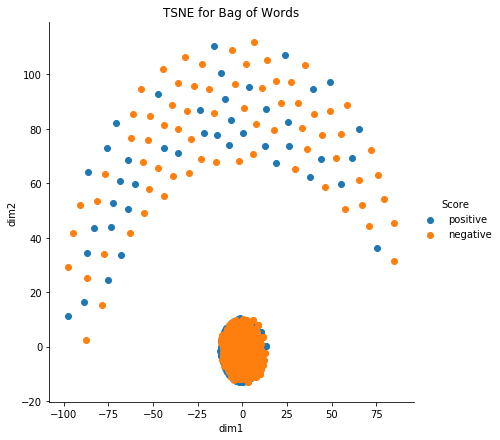

In [51]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity = 50)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

### Amazon fine food review ( tfidf with TSNE)

In [62]:
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 62944)
the number of unique words including both unigrams and bigrams  62944


In [63]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)

In [64]:
std_data.shape

(2000, 62944)

In [65]:
std_data=std_data.toarray()


C:\Users\Jyotiprakash Das\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


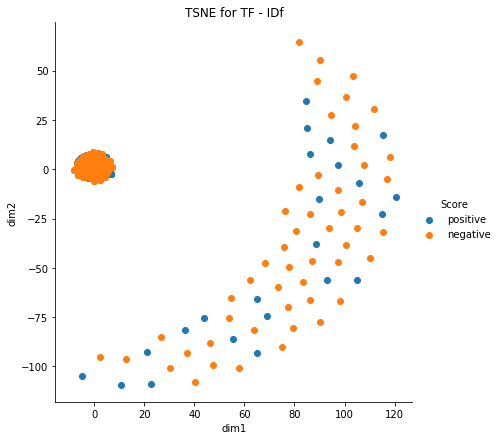

In [66]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity = 50)

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF - IDf")
plt.show()